Reading list : 

https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94

https://en.wikipedia.org/wiki/Multicollinearity

https://en.wikipedia.org/wiki/Ordinary_least_squares

https://en.wikipedia.org/wiki/Occam%27s_razor

https://en.wikipedia.org/wiki/Minimum_description_length

https://towardsdatascience.com/features-correlations-data-leakage-confounded-features-and-other-things-that-can-make-your-deep-771bcaf84f9f

https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables

https://machinelearningmastery.com/data-leakage-machine-learning/

https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383

https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79


data leakage, à cause de la corrélation entre features, le fait de bouger un peu une feature, va non seulement influencer le resultat mais aussi les features elles memes, donc la prédiction sera plus aléatoire

scaling, normalisation, : à ne faire que sur le train set

transformation : à faire sur train et test set




**1. Avancées de l’étudiant sur son projet depuis la dernière session**

Vincent a bien avancé sur le P3; il a effectué le nettoyage de données il est sur la fin.

- Test de plusieurs modèles et benchmark

**2. Principaux sujets abordés pendant la session, obstacles à surmonter (le cas échéant), et actions nécessaires pour atteindre ces objectifs**

Balayage des modèles effectués

- Random Forrest est le meilleur
- XgBoost
- Dummy
- LinearRegression

Correlations à isoler pour éviter le leakage

Passage au log et checker l'impact

StandardScaler - MinMax

**3. Objectifs 'SMART' fixés par l'étudiant et le mentor pour la prochaine session**

- Plusieurs scores RMSE - MSE - R2
- Graphiques sur les resultats des differents modèles
- Avoir une approche iterative sur le travail sur les données
- Ajouter le temps de calcul comme choix de decision
- Analyser les résultats par topologie de bâtiments
    - Surface
    - Etages
    - Type de bâtiments
- Passage au log
- Ajouter les variables catégorielles

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('./tmp/df_cleaned.gzip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3508 entries, 9 to 6698
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               3508 non-null   object 
 1   PrimaryPropertyType        3508 non-null   object 
 2   Neighborhood               3508 non-null   object 
 3   NumberofFloors             3508 non-null   float64
 4   PropertyGFATotal           3508 non-null   float64
 5   PropertyGFABuilding(s)     3508 non-null   float64
 6   LargestPropertyUseType     3508 non-null   object 
 7   LargestPropertyUseTypeGFA  3508 non-null   float64
 8   ENERGYSTARScore            3508 non-null   float64
 9   SiteEUI(kBtu/sf)           3508 non-null   float64
 10  SourceEUI(kBtu/sf)         3508 non-null   float64
 11  SiteEnergyUse(kBtu)        3508 non-null   float64
 12  Electricity(kBtu)          3508 non-null   float64
 13  NaturalGas(kBtu)           3508 non-null   float

In [4]:
# we don't want to rely on the consumption data, because this is costly to get. Our model must do without it
#  but we can keep the proportion of each one, to know for example what is the main energy source of a building

#  TODO : feature engineering here 'proportion'
df['ElectricityRate'] = df['Electricity(kBtu)'] / (df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']+1)
df['NaturalGasRate'] = df['NaturalGas(kBtu)'] / (df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']+1)
df.drop(['Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1, inplace=True)

In [5]:
numerical_features = df.select_dtypes(include=['int64','float64'])
numerical_features_cols = numerical_features.columns.values
categorical_features = df.select_dtypes(exclude=['int64','float64']) 
categorical_features_cols = categorical_features.columns.values

very important article why to normalize features:
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94


In [6]:
agg_func = ['std', 'skew', 'var']
def stats_desc(df):
    print(df.agg(agg_func))

stats_desc(df[numerical_features.columns])

      NumberofFloors  PropertyGFATotal  PropertyGFABuilding(s)  \
std         1.741642      3.108649e+04            2.789908e+04   
skew        0.279240      1.508371e+00            1.511511e+00   
var         3.033318      9.663702e+08            7.783585e+08   

      LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
std                2.567302e+04        24.713452         15.997809   
skew               1.520789e+00        -0.951985          1.017943   
var                6.591037e+08       610.754734        255.929893   

      SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  Latitude  Longitude  \
std            38.955927         1.224978e+06  0.048452    0.02588   
skew            1.039273         1.630447e+00  0.123303   -0.29091   
var          1517.564219         1.500571e+12  0.002348    0.00067   

      TotalGHGEmissions  GHGEmissionsIntensity  BuildingAge  Distance  \
std           33.660378               0.679833    31.956359  2.259337   
skew           1.653986    

In [7]:

# repartition gaz / elec pour un quartier
from sklearn.preprocessing import normalize

neighborhood = df.Neighborhood.unique()
central = df[df.Neighborhood == 'Central']['ElectricityRate'].mean()
electricity = []
for n in neighborhood:
	e_n = df[df.Neighborhood == n]['ElectricityRate'].mean()
	electricity.append(e_n)

gaz = []
for n in neighborhood:
	g_n = df[df.Neighborhood == n]['NaturalGasRate'].mean()
	gaz.append(g_n)

normalized = normalize([electricity, gaz], axis=0)
normalized


array([[0.95734939, 0.97011705, 0.95717834, 0.96479877, 0.94524055,
        0.96632964, 0.92648118, 0.95081956, 0.97191406, 0.97293748,
        0.9797774 , 0.98080304, 0.99377904, 0.96730289, 0.9416013 ,
        0.9963576 , 0.93307193, 0.9189115 ],
       [0.28893278, 0.24263742, 0.28949891, 0.26298923, 0.32637448,
        0.25730726, 0.37634109, 0.30974532, 0.23533604, 0.23106852,
        0.20009061, 0.19500104, 0.1113697 , 0.25362395, 0.33672984,
        0.08527324, 0.35968982, 0.39446376]])

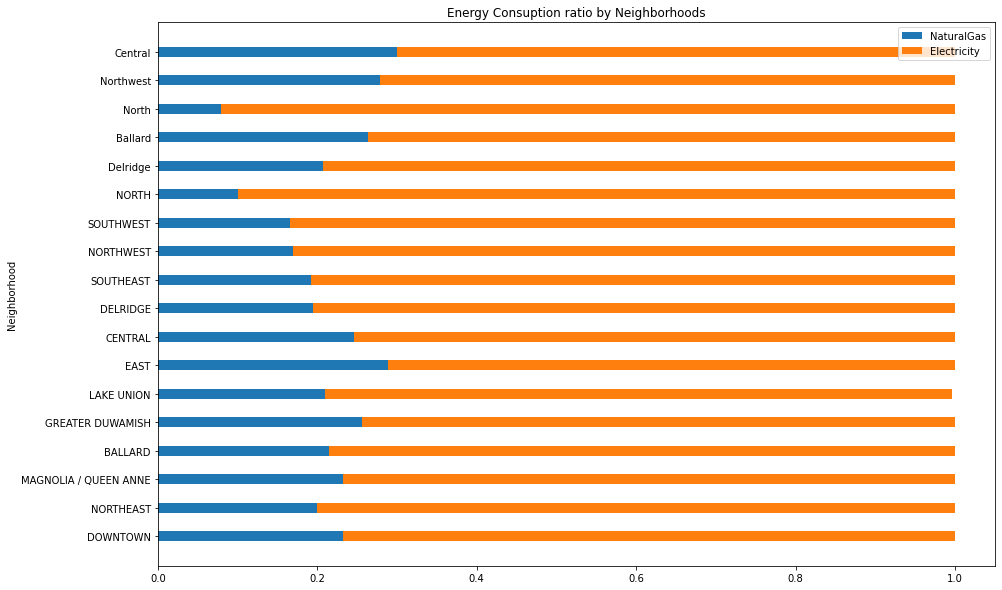

In [8]:
# tmpdf=df[['Neighborhood', 'ElectricityRate', 'NaturalGasRate']]

fig, ax = plt.subplots(figsize=(15,10))
width = 0.35

# ax.barh(tmpdf.Neighborhood, tmpdf.ElectricityRate, width, label='Electricity')
# ax.barh(tmpdf.Neighborhood, tmpdf.NaturalGasRate, width, left=tmpdf.ElectricityRate, label='NaturalGas')

# ax.barh(neighborhood, normalized[0], width, label='NaturalGas')
# ax.barh(neighborhood, normalized[1], width, left=normalized[0], label='Electricity')

ax.barh(neighborhood, gaz, width, label='NaturalGas')
ax.barh(neighborhood, electricity, width, left=gaz, label='Electricity')

# ax.barh(neighborhood, electricity, width, label='Electricity')
# ax.barh(neighborhood, gaz, width, left=electricity, label='NaturalGas')


ax.set_ylabel('Neighborhood')
ax.set_title('Energy Consuption ratio by Neighborhoods')
ax.legend()

plt.show()

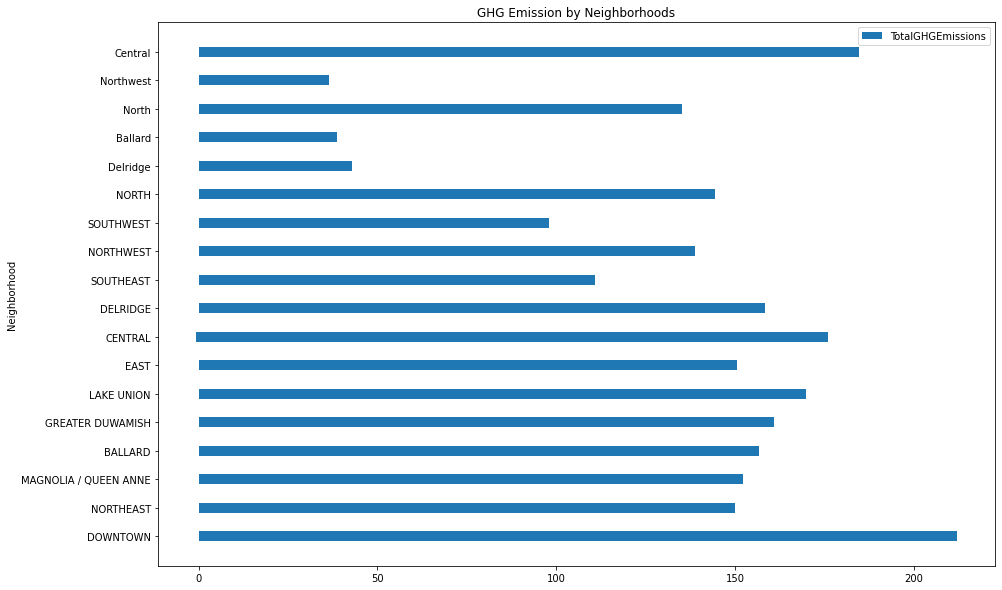

In [9]:
_df=df[['Neighborhood', 'TotalGHGEmissions']]
fig, ax = plt.subplots(figsize=(15,10))
width = 0.35

ax.barh(_df.Neighborhood, _df.TotalGHGEmissions, width, label='TotalGHGEmissions')

ax.set_ylabel('Neighborhood')
ax.set_title('GHG Emission by Neighborhoods')
ax.legend()

plt.show()

In [13]:
# Encoding the categorical features

# from sklearn.preprocessing import OrdinalEncoder

# catenc = OrdinalEncoder()
# catenc.fit(categorical_features)
# catenc.categories_
# categorical_features_enc = catenc.transform(categorical_features)


In [14]:
# TODO WIP

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

catenc = OrdinalEncoder()
numscale = StandardScaler()

prepocessor=ColumnTransformer(transformers=[
	('categories', catenc, categorical_features),
	('numerical', numscale, numerical_features)
])


In [15]:
# generate train and test sets
from sklearn.model_selection import train_test_split

# todo: ENERGYSTARScore should not interfere with our predictions
# TotalGHGEmission is the feature we want to predict
prediction = 'TotalGHGEmissions'

# X = numerical_features.drop([prediction, 'ENERGYSTARScore'], axis=1)
# y = numerical_features[prediction]
X = df.drop([prediction], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2455, 19) (1053, 19)
(2455,) (1053,)


In [17]:
df.var().round(2)

NumberofFloors               3.030000e+00
PropertyGFATotal             9.663702e+08
PropertyGFABuilding(s)       7.783585e+08
LargestPropertyUseTypeGFA    6.591037e+08
ENERGYSTARScore              6.107500e+02
SiteEUI(kBtu/sf)             2.559300e+02
SourceEUI(kBtu/sf)           1.517560e+03
SiteEnergyUse(kBtu)          1.500571e+12
Latitude                     0.000000e+00
Longitude                    0.000000e+00
TotalGHGEmissions            1.133020e+03
GHGEmissionsIntensity        4.600000e-01
BuildingAge                  1.021210e+03
Distance                     5.100000e+00
ElectricityRate              7.000000e-02
NaturalGasRate               7.000000e-02
dtype: float64

In [18]:
df.skew().round(2)

NumberofFloors               0.28
PropertyGFATotal             1.51
PropertyGFABuilding(s)       1.51
LargestPropertyUseTypeGFA    1.52
ENERGYSTARScore             -0.95
SiteEUI(kBtu/sf)             1.02
SourceEUI(kBtu/sf)           1.04
SiteEnergyUse(kBtu)          1.63
Latitude                     0.12
Longitude                   -0.29
TotalGHGEmissions            1.65
GHGEmissionsIntensity        1.53
BuildingAge                  0.59
Distance                     0.74
ElectricityRate             -0.89
NaturalGasRate               0.89
dtype: float64

certaines features ne suivent pas des distributions normales, mais on peut les transformer pour y parvenir: 

TODO : remove negative values (PropertyGFABuilding, for inst.)

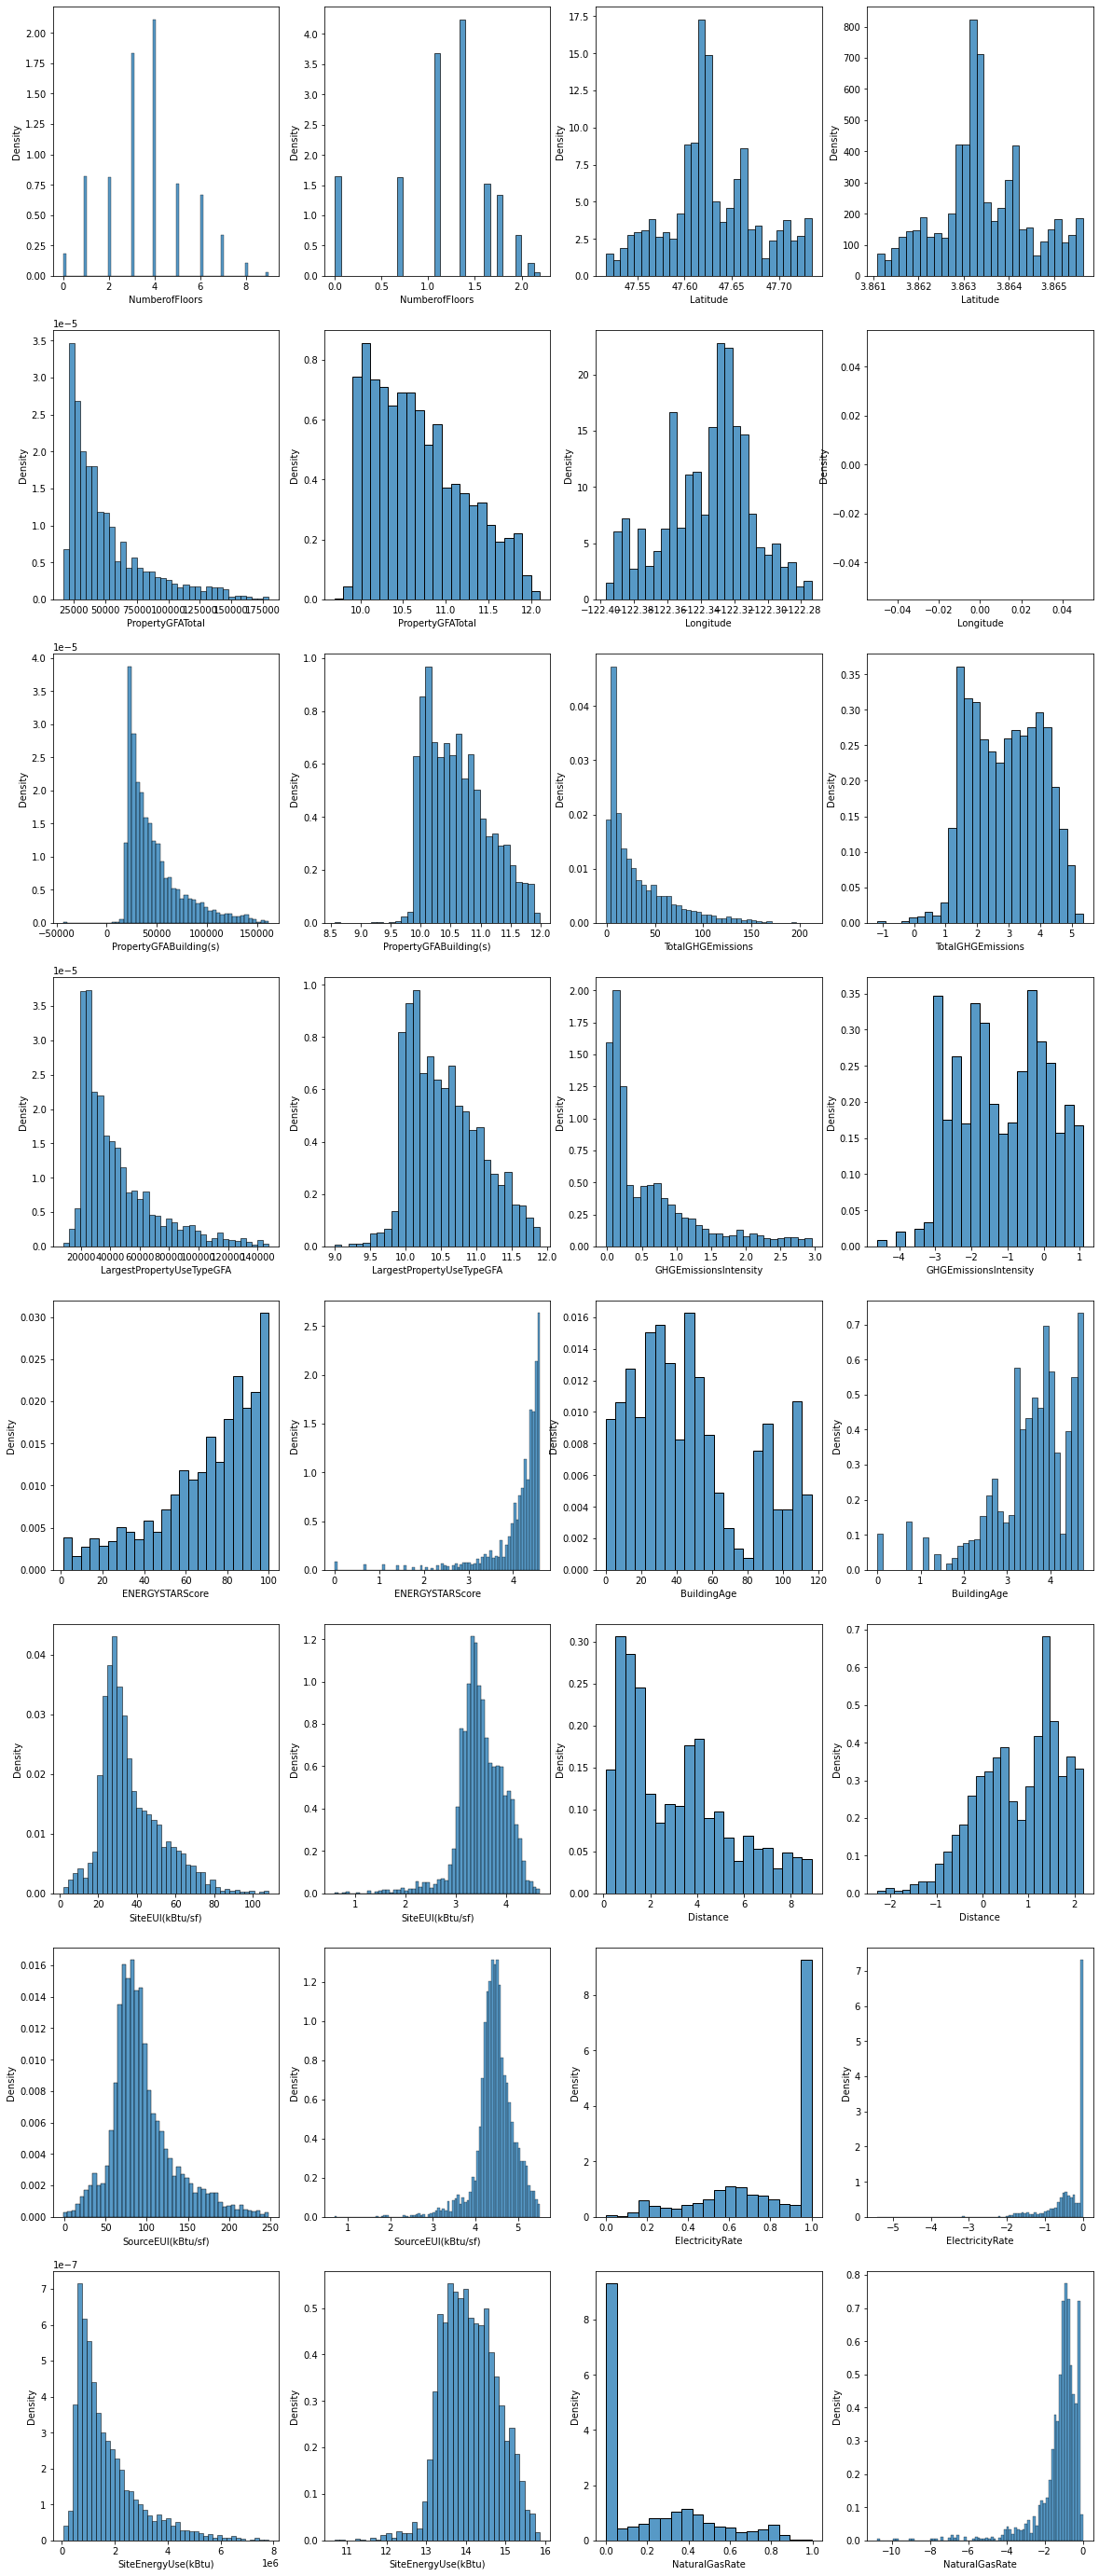

In [110]:
from sklearn.preprocessing import FunctionTransformer
# on regarde le resultat du passage au log pour certaines features, si cela permet d'avoir une distribution normale
# TODO WIP

to_log_features = df.select_dtypes(['float', 'int']).columns
size = to_log_features.shape[0]

nrows = int(size/2)
ncols = int(size/4)
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(20,50))

for i, col in enumerate(to_log_features):
	logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
	y_log = logtransformer.transform(df[col])

	# print(f'ploting first on ({i%nrows},{ i//nrows * 2}), second on ({i%nrows},{1 + i//nrows * 2})')
	
	sns.histplot(data=df[col], stat="density", ax=ax[i%nrows, i//nrows * 2])#.set_title(col)
	# ax[0].set_title("Without log")
	
	sns.histplot(data=y_log, stat="density", ax=ax[i%nrows, 1 + i//nrows * 2])#.set_title(f'{col}-log')
	# ax[1].set_title("With log")

plt.show()

In [50]:
from sklearn.preprocessing import StandardScaler

# on regarde le resultat du scale pour certaines features, si cela permet d'avoir une distribution normale
# TODO WIP

to_scale_features = df.select_dtypes(['float', 'int']).columns

for col in to_scale_features:
	scaler = StandardScaler()
	print(scaler.fit(df[col]))
	# y_log = scaler.fit_transform(df[col])

	# fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,5))

	# sns.histplot(data=df[col], stat="density", ax=ax[0])
	# ax[0].set_title("Without log")

	# sns.histplot(data=y_log, stat="density", ax=ax[1])
	# ax[1].set_title("With log")

	# plt.show()

NumberofFloors


ValueError: Expected 2D array, got 1D array instead:
array=[6. 6. 5. ... 7. 6. 4.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
# we use a scaler
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(df[numerical_features_cols])
X_std = std_scale.transform(df[numerical_features_cols])
X_std.shape
# np.histogram(X_std)

(3508, 16)

In [23]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PowerTransformer

# Set up the colnames
to_scale = ["depth", "table", "x", "y", "z"]
to_log = ["price", "carat"]
categorical = df.select_dtypes(include="category").columns

scale_pipe = make_pipeline(StandardScaler())
log_pipe = make_pipeline(PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))

transformer = ColumnTransformer(
    transformers=[
        ("scale", scale_pipe, to_scale),
        ("log_transform", log_pipe, to_log),
        ("oh_encode", categorical_pipe, categorical),
    ]
)

NameError: name 'OneHotEncoder' is not defined

In [24]:
# categorical features : they are only nominal (not cardinal),
# thus we could encode them with OneHotEncoder (not OrdinalEncoder)
from sklearn.preprocessing import OneHotEncoder

cols = X_train.select_dtypes('object').columns
X_train[cols]
enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
enc.fit(X_train[cols])
enc.categories_
X_col_enc = enc.transform(X_train[cols])
X_col_enc.shape
# enc.get_feature_names_out

(2455, 69)

In [25]:

from sklearn.dummy import DummyRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from datetime import datetime


# we use a scaler
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)


# def printModelScores(y_pred, y_test):
# 	print(f'RMSE : {np.sqrt(mean_squared_error(y_pred, y_test))}')
# 	print(f'MAE : {mean_absolute_error(y_pred, y_test)}')
# 	print(f'R2 : {r2_score(y_pred, y_test)}')

def runModel(model, params={}):
	start_time = datetime.now()
	pipe = make_pipeline(
		StandardScaler(),
		
		GridSearchCV(
			estimator=model, 
			cv=5, 
			param_grid=params)
	)
	pipe.fit(X_train_std, y_train)


	gs = GridSearchCV(
		estimator=model, 
		cv=5, 
		param_grid=params)
	gs.fit(X_train_std, y_train)
	end_time = datetime.now()
	
	ellapsed_time = end_time - start_time
	y_pred = gs.predict(X_test_std)
	
	ret = {
		'model' : type(model).__name__,
		'compute_time' : ellapsed_time,
		'best_params' : gs.best_params_,
		'RMSE' : np.sqrt(mean_squared_error(y_pred, y_test)),
		'MAE' : mean_absolute_error(y_pred, y_test),
		'R2' : r2_score(y_pred, y_test)
	}

	print(f'result for model {ret["model"]}')
	print(f'   computation time: {ret["compute_time"]}')
	print(f'   best params: {ret["best_params"]}')
	print(f'   RMSE : {ret["RMSE"]}')
	print(f'   MAE : {ret["MAE"]}')
	print(f'   R2 : {ret["R2"]}')

	return ret	





ValueError: could not convert string to float: 'NonResidential'

In [26]:
np.var(X_train_std)

NameError: name 'X_train_std' is not defined

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(np.cov(X_train_std))

NameError: name 'X_train_std' is not defined

<Figure size 720x720 with 0 Axes>

In [22]:
import matplotlib
plt.figure(figsize=(10,10))
plt.pcolor(np.cov(X_train_std), cmap=matplotlib.cm.PuRd)
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

NameError: name 'X_train_std' is not defined

<Figure size 720x720 with 0 Axes>

In [19]:

# Dummy regressor as a baseline
runModel(DummyRegressor(strategy="mean"))



result for model DummyRegressor
   computation time: 0:00:00.015094
   best params: {}
   RMSE : 33.29718586610974
   MAE : 25.632308798641454
   R2 : -8.784046871130898e+31


{'model': 'DummyRegressor',
 'compute_time': datetime.timedelta(microseconds=15094),
 'best_params': {},
 'RMSE': 33.29718586610974,
 'MAE': 25.632308798641454,
 'R2': -8.784046871130898e+31}

In [20]:
# Dummy regressor as a baseline
runModel(DummyRegressor(strategy="mean"))

# LinearRegression
# TODO WIP
params_gscv = {

}

runModel(LinearRegression(), params_gscv)

# lr_grid_cv = Pipeline([
# 	# ('preprocessor', prepocessor),
# 	('gridsearchcv', GridSearchCV(
# 		estimator=LinearRegression(), 
# 		param_grid=params_gscv,
# 		cv=5
# 	))]
# )


result for model DummyRegressor
   computation time: 0:00:00.015063
   best params: {}
   RMSE : 33.29718586610974
   MAE : 25.632308798641454
   R2 : -8.784046871130898e+31
result for model LinearRegression
   computation time: 0:00:00.028455
   best params: {}
   RMSE : 10.697543868409033
   MAE : 7.130979462914104
   R2 : 0.8874224475108248


{'model': 'LinearRegression',
 'compute_time': datetime.timedelta(microseconds=28455),
 'best_params': {},
 'RMSE': 10.697543868409033,
 'MAE': 7.130979462914104,
 'R2': 0.8874224475108248}

In [23]:
from sklearn.ensemble import RandomForestRegressor
import os

parameters = {
    'n_estimators' : [10,50,100,300,500],
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt']
}

runModel(RandomForestRegressor(n_jobs=os.cpu_count()), parameters)

result for model RandomForestRegressor
   computation time: 0:01:10.625929
   best params: {'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}
   RMSE : 2.8037231365171333
   MAE : 1.3700392212725538
   R2 : 0.9926717540999462


{'model': 'RandomForestRegressor',
 'compute_time': datetime.timedelta(seconds=70, microseconds=625929),
 'best_params': {'max_features': 'auto',
  'min_samples_leaf': 1,
  'n_estimators': 300},
 'RMSE': 2.8037231365171333,
 'MAE': 1.3700392212725538,
 'R2': 0.9926717540999462}

In [24]:
# Linear SVR
from sklearn.svm import LinearSVR

parameters_svr = {
	'C' : np.logspace(-2, -1, 10),
	'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

runModel(LinearSVR(), parameters_svr)

result for model LinearSVR
   computation time: 0:00:00.524325
   best params: {'C': 0.0774263682681127, 'loss': 'squared_epsilon_insensitive'}
   RMSE : 10.712248424417135
   MAE : 7.157640782508006
   R2 : 0.8864515327978735


{'model': 'LinearSVR',
 'compute_time': datetime.timedelta(microseconds=524325),
 'best_params': {'C': 0.0774263682681127,
  'loss': 'squared_epsilon_insensitive'},
 'RMSE': 10.712248424417135,
 'MAE': 7.157640782508006,
 'R2': 0.8864515327978735}

In [23]:
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

xgb.set_config(verbosity=0)

parameters_xgb = {
	'n_estimators' : [200, 500, 1000],
	'max_depth' : [2, 5, 10]
}

runModel(XGBRegressor(n_jobs=os.cpu_count()), parameters_xgb)

# xgbr = GridSearchCV(XGBRegressor(n_jobs=os.cpu_count()), cv=5, param_grid=parameters_xgb)
# xgbr.fit(X_train_std, y_train)

result for model XGBRegressor
   computation time: 0:05:21.596024
   best params: {'max_depth': 2, 'n_estimators': 1000}
   RMSE : 3.3853284690771495
   MAE : 1.9674404243311197
   R2 : 0.9891032544819024


{'model': 'XGBRegressor',
 'compute_time': datetime.timedelta(seconds=321, microseconds=596024),
 'best_params': {'max_depth': 2, 'n_estimators': 1000},
 'RMSE': 3.3853284690771495,
 'MAE': 1.9674404243311197,
 'R2': 0.9891032544819024}

In [25]:
# knn regressor
from sklearn.neighbors import KNeighborsRegressor

parameters_knn = {
	'n_neighbors' : [2, 4, 8, 10, 16]
}

runModel(KNeighborsRegressor(), parameters_knn)

result for model KNeighborsRegressor
   computation time: 0:00:00.635321
   best params: {'n_neighbors': 2}
   RMSE : 8.811276612192026
   MAE : 4.523333333333333
   R2 : 0.9261179571653779


{'model': 'KNeighborsRegressor',
 'compute_time': datetime.timedelta(microseconds=635321),
 'best_params': {'n_neighbors': 2},
 'RMSE': 8.811276612192026,
 'MAE': 4.523333333333333,
 'R2': 0.9261179571653779}

In [26]:
from sklearn.linear_model import Ridge

parameters_ridge = {
	'alpha' : np.logspace(-5, 5, 200)
}

runModel(Ridge(), parameters_ridge)

result for model Ridge
   computation time: 0:00:03.764815
   best params: {'alpha': 6.747544053110699}
   RMSE : 10.713221155166087
   MAE : 7.150081118442387
   R2 : 0.8863955729407985


{'model': 'Ridge',
 'compute_time': datetime.timedelta(seconds=3, microseconds=764815),
 'best_params': {'alpha': 6.747544053110699},
 'RMSE': 10.713221155166087,
 'MAE': 7.150081118442387,
 'R2': 0.8863955729407985}

In [27]:
from sklearn.linear_model import Lasso

parameters_lasso = {
	'alpha' : np.logspace(-5, 1, 300)
}

runModel(Lasso(), parameters_lasso)

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import ElasticNet

parameters_net = {
	'alpha' : np.logspace(-5, 1, 300),
	# 'l1_ratio' : np.logspace(-5, 1, 300)
}

runModel(ElasticNet(), parameters_net)

result for model ElasticNet
   computation time: 0:00:27.044733
   best params: {'alpha': 0.010233717986325202}
   RMSE : 11.218990686827635
   MAE : 7.38149107725266
   R2 : 0.87972901449258


{'model': 'ElasticNet',
 'compute_time': datetime.timedelta(seconds=27, microseconds=44733),
 'best_params': {'alpha': 0.010233717986325202},
 'RMSE': 11.218990686827635,
 'MAE': 7.38149107725266,
 'R2': 0.87972901449258}

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pipe_svc = make_pipeline(StandardScaler(),PCA(n_components=2),SVC(random_state=1))
# param_range = [0.001,0.01,0.1,1,10,100,1000]
param_grid = {'svc__C': [0.001,0.01,0.1,1,10,100,1000], 'svc__kernel': ['linear', 'rbf'],
              'svc__gamma': [0.001,0.01,0.1,1,10,100,1000]}
cv = StratifiedKFold(n_splits=5)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid, scoring='accuracy', cv = cv,
                  return_train_score=True)
gs.fit(X_train, y_train)

print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print("Best Training Score: \n{}\n".format(gs.cv_results_['mean_train_score'][gs.best_index_]))
print("All Training Scores: \n{}\n".format(gs.cv_results_['mean_train_score']))
print("All Test Scores: \n{}\n".format(gs.cv_results_['mean_test_score']))
# # This prints out all results during Cross-Validation in details
print("All Meta Results During CV Search: \n{}\n".format(gs.cv_results_))


Best Estimator: 
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('svc', SVC(C=10, gamma=0.001, random_state=1))])

Best Parameters: 
{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Best Test Score: 
0.9321202531645569

Best Training Score: 
0.9296484690759252

All Training Scores: 
[0.89572958 0.62814219 0.89572958 0.62814219 0.89572958 0.62814219
 0.89572958 0.62814219 0.89572958 0.62814219 0.89572958 0.62814219
 0.89572958 0.62814219 0.92776365 0.62814219 0.92776365 0.62814219
 0.92776365 0.62814219 0.92776365 0.62814219 0.92776365 0.62814219
 0.92776365 0.62814219 0.92776365 0.62814219 0.93530096 0.68719071
 0.93530096 0.91708563 0.93530096 0.93027149 0.93530096 0.88693835
 0.93530096 0.62814219 0.93530096 0.62814219 0.93530096 0.62814219
 0.93718578 0.91834152 0.93718578 0.92901954 0.93718578 0.93530293
 0.93718578 0.95665701 0.93718578 0.97739004 0.93718578 0.99811715
 0.93718578 1.         0.94032058 